In [21]:
from model import EyeDiseaseClassifierCNN

In [22]:
import torch 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import random
import copy

from sklearn.metrics import confusion_matrix,classification_report

In [23]:
import wandb

In [24]:
num_epochs = 20

In [25]:
wandb.init(
    # set the wandb entity where your project will be logged (generally your team name)
    entity="oleksii-oliinyk-lviv-polytechnic-national-university",

    # set the wandb project where this run will be logged
    project="eye-disease-classifier",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "CNN",
    "dataset": "custom-eye-disease-dataset",
    "epochs": num_epochs,
    }
)

In [26]:
transform = transforms.Compose([
    transforms.Resize(640),
    transforms.RandomResizedCrop(size=640, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),
    transforms.RandomAutocontrast(p=0.3),
    transforms.ToTensor(),
])

In [ ]:
dataset = datasets.ImageFolder(root="processed_dataset/training/", transform=transform)

val_dataset = datasets.ImageFolder(root="processed_dataset/validation/", transform=transform)


total_size = len(dataset)
train_size = int(0.9 * total_size)
test_size = total_size - train_size 

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=False)


In [28]:
dataset.class_to_idx

{'a_healthy_eye': 0,
 'cataract': 1,
 'dry_eye_syndrome': 2,
 'exopthalmos': 3,
 'jaundice': 4,
 'pterygium': 5,
 'stye': 6,
 'subcon_hemorrage': 7}

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [30]:
device

device(type='cuda')

In [31]:
def model_train(model, optimizer, criterion, dataloader):
    model.train()
    actual = []
    predicted = []

    
    for batch in dataloader:
        images, labels = batch
        labels = labels.to(device)
        images = images.to(device)
        
        preds = model(images) 
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _, predicted_classes = torch.max(preds, 1)
        
        for label in labels.tolist(): actual.append(int(label))
        for predicted_class in predicted_classes.tolist(): predicted.append(int(predicted_class))
    
    actual = np.array(actual) 
    predicted = np.array(predicted)
    
    return actual, predicted

In [32]:
def model_eval(model,dataloader):
    model.eval()
    actual = []
    predicted = []
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            
            labels = labels.to(device)
            images = images.to(device)
            
            preds = model(images)
            #loss = criterion(preds, labels)
            
            _, predicted_classes = torch.max(preds, 1)
            
            for label in labels.tolist(): actual.append(int(label))
            for predicted_class in predicted_classes.tolist(): predicted.append(int(predicted_class)) 
        
    actual = np.array(actual) 
    predicted = np.array(predicted)
    
    return actual, predicted

In [33]:
def create_confusion_matrix(actual,predicted, epoch):
    
    cm = confusion_matrix(actual,predicted)
    sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=['a_healthy_eye','cataract','dry_eye_syndrome','exopthalmos','jaundice','pterygium','stye','subcon_hemorrage'],
            yticklabels=['a_healthy_eye','cataract','dry_eye_syndrome','exopthalmos','jaundice','pterygium','stye','subcon_hemorrage'])
    plt.ylabel('Actual', fontsize=13)
    plt.title(f'Eval Confusion Matrix - Epoch #{epoch+1}', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()

    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [34]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [35]:
learning_rate = 0.0001

model = EyeDiseaseClassifierCNN().to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)  # base lr is not critical, OneCycleLR overrides it

In [36]:
f = open("../logs/classification/classifier_training_Adam_early_stopping_5.txt", "w")

In [37]:
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=3e-3,  # Slightly lower than 1e-2, more stable for Adam
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.3,  # 30% warmup
    div_factor=10,  # Initial LR = max_lr / 10
    final_div_factor=100,  # Final LR = max_lr / 100
    anneal_strategy='cos'  # Cosine annealing
)

Epoch #1 -> lr = 0.0002999999999999999


Training: 
              precision    recall  f1-score   support

           0       0.38      0.38      0.38       329
           1       0.34      0.35      0.35       298
           2       0.19      0.18      0.19       206
           3       0.16      0.14      0.15        79
           4       0.35      0.39      0.37       181
           5       0.43      0.44      0.44       276
           6       0.34      0.35      0.35       260
           7       0.18      0.17      0.17       162

    accuracy                           0.33      1791
   macro avg       0.30      0.30      0.30      1791
weighted avg       0.32      0.33      0.33      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.40      0.27      0.32        30
           1       0.77      0.29      0.42        35
           2       0.32      0.58      0.42        19
           3       0.00      0.00      0.00        12
           4       0.65      0.79      0.71        28


d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


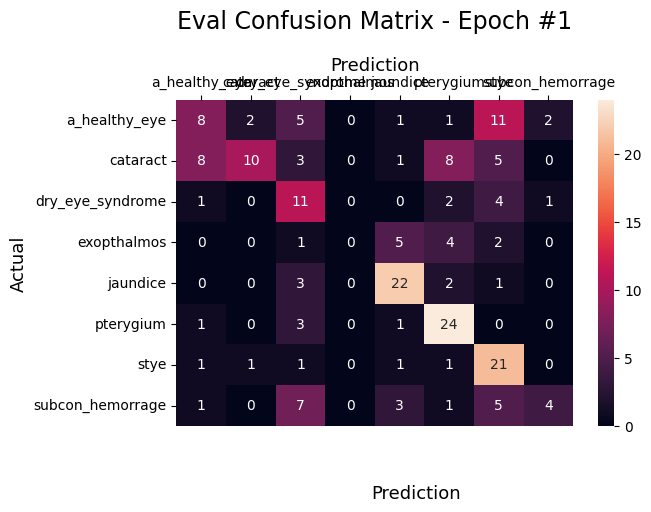

Current f1_score ->  0.4217274222531374
Epoch #2 -> lr = 0.00030002293109314187
Training: 
              precision    recall  f1-score   support

           0       0.52      0.57      0.54       329
           1       0.48      0.44      0.46       298
           2       0.33      0.33      0.33       206
           3       0.44      0.30      0.36        79
           4       0.66      0.65      0.65       181
           5       0.66      0.74      0.70       276
           6       0.56      0.57      0.57       260
           7       0.35      0.31      0.33       162

    accuracy                           0.52      1791
   macro avg       0.50      0.49      0.49      1791
weighted avg       0.51      0.52      0.52      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.53      0.27      0.36        30
           1       0.59      0.77      0.67        35
           2       0.25      0.47      0.33        19
           3       0.60     

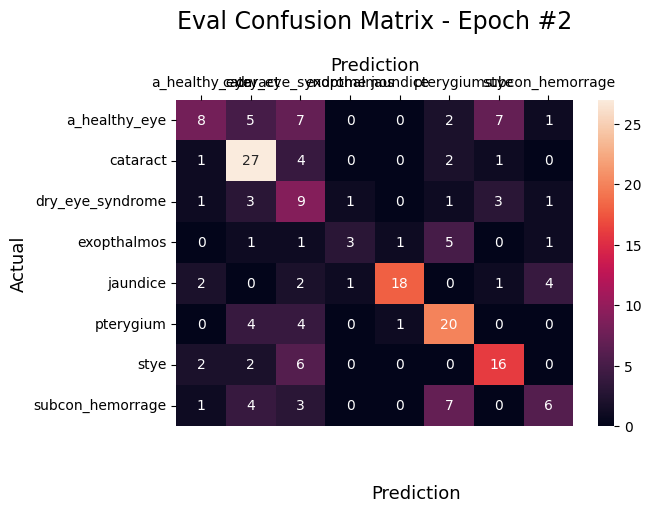

Current f1_score ->  0.5005038126361656
Epoch #3 -> lr = 0.000300091723593552
Training: 
              precision    recall  f1-score   support

           0       0.61      0.63      0.62       329
           1       0.57      0.63      0.60       298
           2       0.55      0.50      0.52       206
           3       0.47      0.33      0.39        79
           4       0.80      0.80      0.80       181
           5       0.72      0.81      0.76       276
           6       0.62      0.63      0.63       260
           7       0.60      0.46      0.52       162

    accuracy                           0.63      1791
   macro avg       0.62      0.60      0.60      1791
weighted avg       0.63      0.63      0.63      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        30
           1       0.78      0.40      0.53        35
           2       0.44      0.58      0.50        19
           3       0.50      0

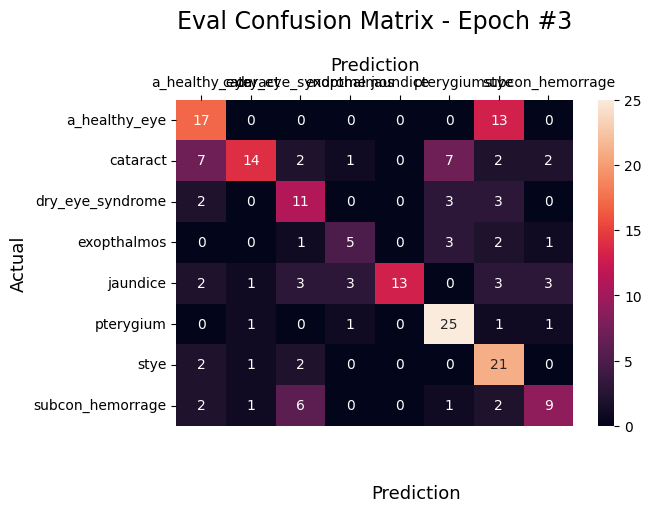

Current f1_score ->  0.5578129811828108
Epoch #4 -> lr = 0.000300206375164213
Training: 
              precision    recall  f1-score   support

           0       0.74      0.76      0.75       329
           1       0.68      0.66      0.67       298
           2       0.55      0.54      0.55       206
           3       0.55      0.35      0.43        79
           4       0.85      0.82      0.83       181
           5       0.71      0.77      0.74       276
           6       0.64      0.70      0.67       260
           7       0.58      0.54      0.56       162

    accuracy                           0.68      1791
   macro avg       0.66      0.64      0.65      1791
weighted avg       0.68      0.68      0.68      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        30
           1       0.55      0.74      0.63        35
           2       0.46      0.63      0.53        19
           3       0.75      0

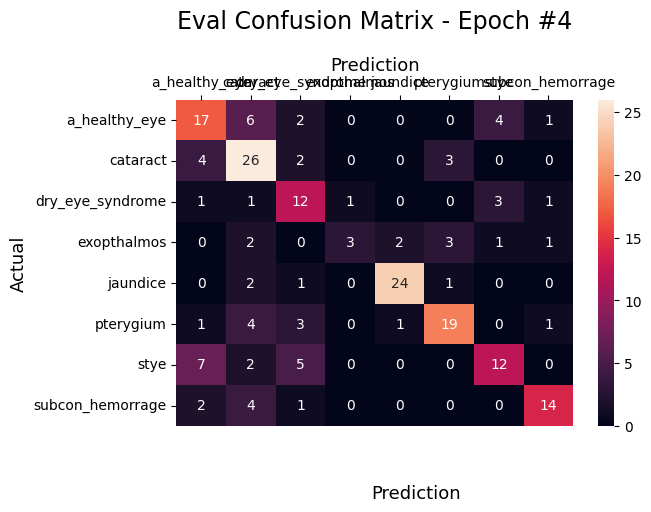

Current f1_score ->  0.6117738729488507
Epoch #5 -> lr = 0.00030036688191018273
Training: 
              precision    recall  f1-score   support

           0       0.74      0.77      0.76       329
           1       0.74      0.75      0.74       298
           2       0.69      0.67      0.68       206
           3       0.75      0.53      0.62        79
           4       0.82      0.84      0.83       181
           5       0.78      0.80      0.79       276
           6       0.72      0.75      0.73       260
           7       0.69      0.64      0.66       162

    accuracy                           0.74      1791
   macro avg       0.74      0.72      0.73      1791
weighted avg       0.74      0.74      0.74      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.81      0.43      0.57        30
           1       0.62      0.89      0.73        35
           2       0.82      0.47      0.60        19
           3       0.67     

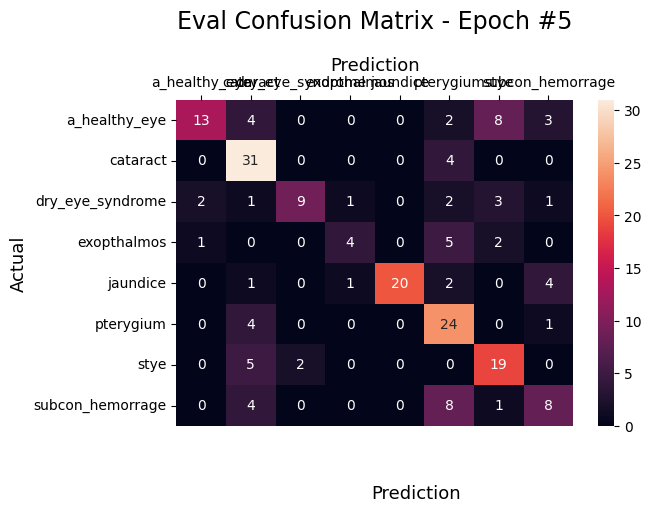

Current f1_score ->  0.6086382886681931
Epoch #6 -> lr = 0.00030057323837872664
Training: 
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       329
           1       0.76      0.75      0.75       298
           2       0.66      0.63      0.64       206
           3       0.67      0.58      0.62        79
           4       0.85      0.88      0.87       181
           5       0.81      0.83      0.82       276
           6       0.76      0.76      0.76       260
           7       0.72      0.70      0.71       162

    accuracy                           0.75      1791
   macro avg       0.75      0.74      0.74      1791
weighted avg       0.75      0.75      0.75      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.64      0.47      0.54        30
           1       0.68      0.71      0.69        35
           2       0.32      0.74      0.44        19
           3       0.83     

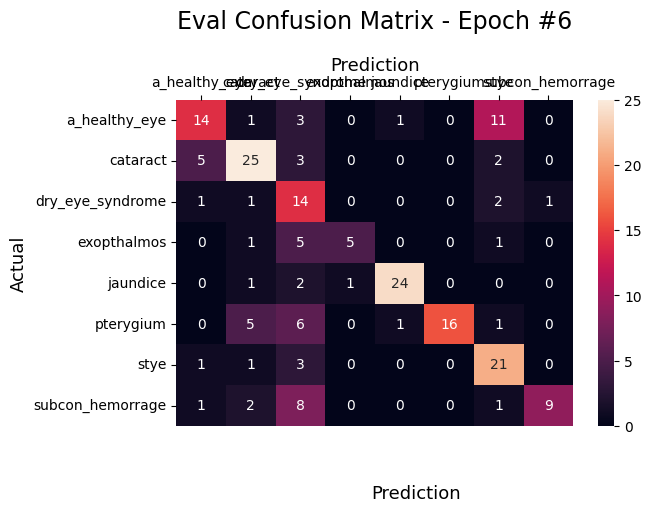

Current f1_score ->  0.632463123793769
Epoch #7 -> lr = 0.0003008254375595062
Training: 
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       329
           1       0.78      0.79      0.78       298
           2       0.71      0.70      0.71       206
           3       0.77      0.71      0.74        79
           4       0.90      0.88      0.89       181
           5       0.78      0.81      0.80       276
           6       0.79      0.78      0.79       260
           7       0.72      0.67      0.69       162

    accuracy                           0.78      1791
   macro avg       0.78      0.77      0.77      1791
weighted avg       0.78      0.78      0.78      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.43      0.90      0.58        30
           1       0.65      0.49      0.56        35
           2       0.88      0.37      0.52        19
           3       0.67      0

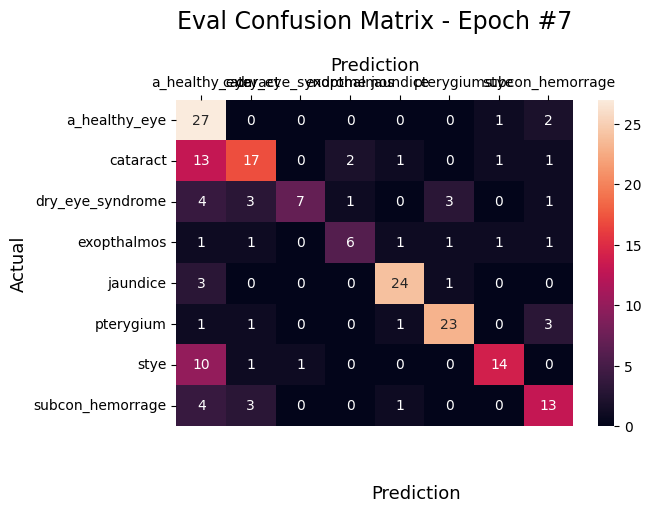

Current f1_score ->  0.6452925138956925
Epoch #8 -> lr = 0.00030112347088481284
Training: 
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       329
           1       0.76      0.78      0.77       298
           2       0.69      0.69      0.69       206
           3       0.76      0.61      0.68        79
           4       0.87      0.88      0.87       181
           5       0.82      0.84      0.83       276
           6       0.75      0.79      0.77       260
           7       0.77      0.73      0.75       162

    accuracy                           0.78      1791
   macro avg       0.78      0.76      0.77      1791
weighted avg       0.78      0.78      0.78      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.68      0.77      0.72        30
           1       0.77      0.77      0.77        35
           2       0.64      0.37      0.47        19
           3       0.50     

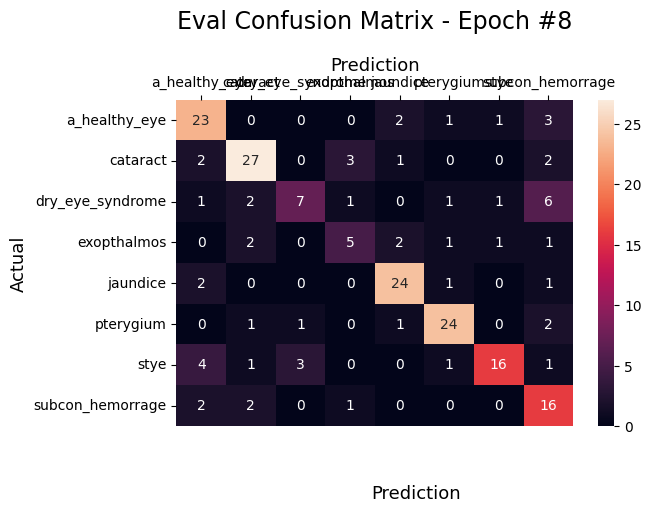

Current f1_score ->  0.6726809753063209
Epoch #9 -> lr = 0.00030146732822986183
Training: 
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       329
           1       0.82      0.83      0.82       298
           2       0.76      0.70      0.73       206
           3       0.82      0.82      0.82        79
           4       0.91      0.87      0.89       181
           5       0.84      0.86      0.85       276
           6       0.84      0.81      0.82       260
           7       0.75      0.74      0.75       162

    accuracy                           0.81      1791
   macro avg       0.81      0.81      0.81      1791
weighted avg       0.81      0.81      0.81      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        30
           1       0.66      0.66      0.66        35
           2       0.71      0.63      0.67        19
           3       0.75     

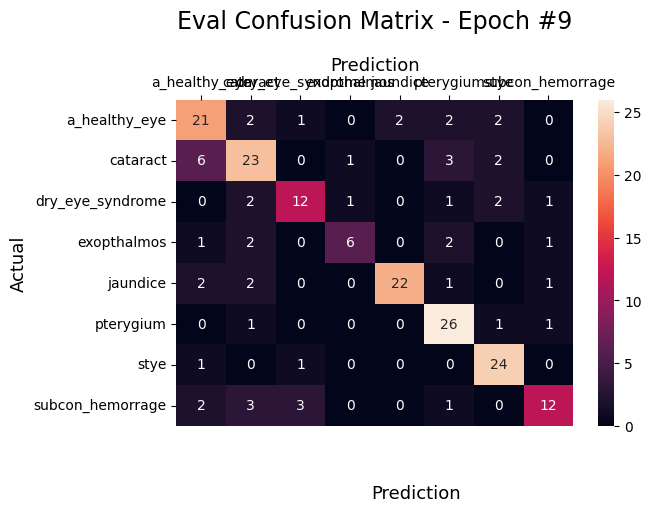

Current f1_score ->  0.7159229935545725
Epoch #10 -> lr = 0.00030185699791313416
Training: 
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       329
           1       0.84      0.84      0.84       298
           2       0.80      0.81      0.80       206
           3       0.77      0.71      0.74        79
           4       0.91      0.90      0.90       181
           5       0.88      0.89      0.89       276
           6       0.82      0.82      0.82       260
           7       0.79      0.77      0.78       162

    accuracy                           0.83      1791
   macro avg       0.83      0.82      0.82      1791
weighted avg       0.83      0.83      0.83      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.69      0.37      0.48        30
           1       0.93      0.40      0.56        35
           2       0.48      0.63      0.55        19
           3       0.77    

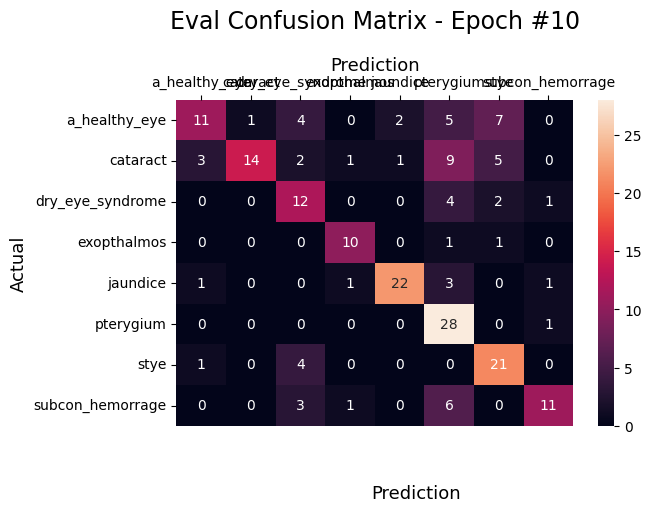

Current f1_score ->  0.6473398008858686
Epoch #11 -> lr = 0.00030229246669677586
Training: 
              precision    recall  f1-score   support

           0       0.82      0.81      0.82       329
           1       0.78      0.81      0.80       298
           2       0.78      0.77      0.77       206
           3       0.87      0.77      0.82        79
           4       0.91      0.92      0.92       181
           5       0.82      0.84      0.83       276
           6       0.77      0.77      0.77       260
           7       0.75      0.72      0.73       162

    accuracy                           0.81      1791
   macro avg       0.81      0.80      0.81      1791
weighted avg       0.81      0.81      0.81      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.68      0.63      0.66        30
           1       0.72      0.83      0.77        35
           2       0.69      0.47      0.56        19
           3       0.67    

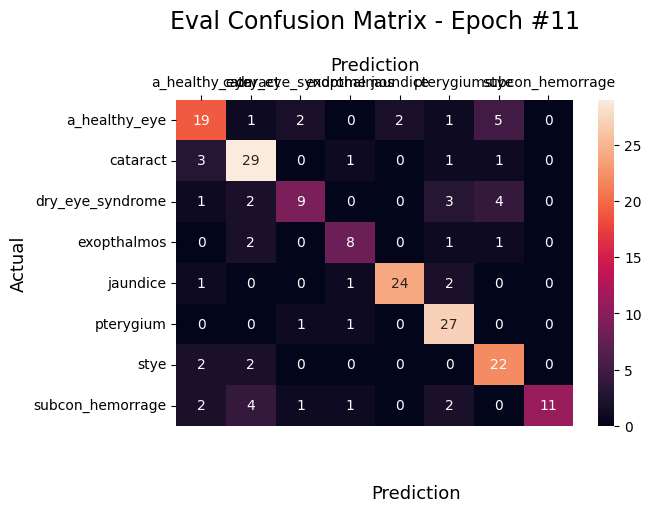

Current f1_score ->  0.7247507290910271
Epoch #12 -> lr = 0.00030277371978704604
Training: 
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       329
           1       0.86      0.88      0.87       298
           2       0.82      0.82      0.82       206
           3       0.82      0.80      0.81        79
           4       0.95      0.93      0.94       181
           5       0.92      0.92      0.92       276
           6       0.88      0.87      0.88       260
           7       0.84      0.84      0.84       162

    accuracy                           0.88      1791
   macro avg       0.87      0.87      0.87      1791
weighted avg       0.88      0.88      0.88      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.64      0.77      0.70        30
           1       0.69      0.69      0.69        35
           2       0.80      0.63      0.71        19
           3       0.83    

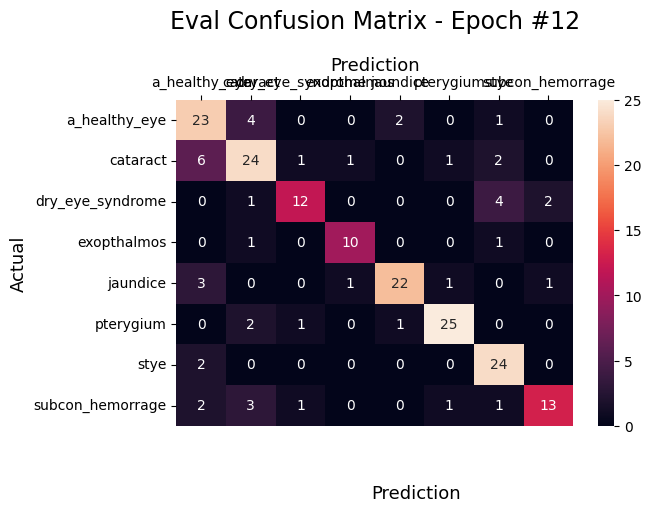

Current f1_score ->  0.7681929194245647
Epoch #13 -> lr = 0.0003033007408348191
Training: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       329
           1       0.87      0.86      0.87       298
           2       0.80      0.80      0.80       206
           3       0.86      0.85      0.85        79
           4       0.94      0.92      0.93       181
           5       0.88      0.91      0.89       276
           6       0.85      0.87      0.86       260
           7       0.88      0.88      0.88       162

    accuracy                           0.87      1791
   macro avg       0.87      0.87      0.87      1791
weighted avg       0.87      0.87      0.87      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.82      0.60      0.69        30
           1       0.84      0.74      0.79        35
           2       1.00      0.32      0.48        19
           3       0.67     

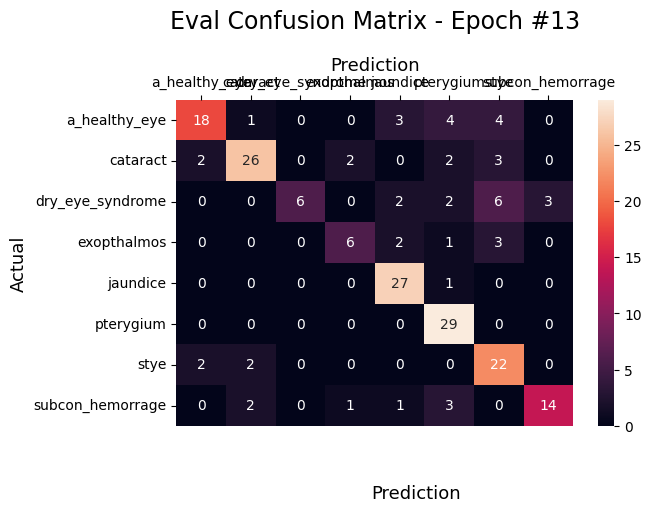

Current f1_score ->  0.7037501778089713
Epoch #14 -> lr = 0.00030387351193614156
Training: 
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       329
           1       0.85      0.86      0.86       298
           2       0.83      0.80      0.82       206
           3       0.87      0.84      0.85        79
           4       0.94      0.92      0.93       181
           5       0.90      0.91      0.91       276
           6       0.85      0.88      0.87       260
           7       0.85      0.82      0.84       162

    accuracy                           0.87      1791
   macro avg       0.87      0.86      0.86      1791
weighted avg       0.87      0.87      0.87      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.67      0.60      0.63        30
           1       0.77      0.86      0.81        35
           2       0.57      0.84      0.68        19
           3       0.75    

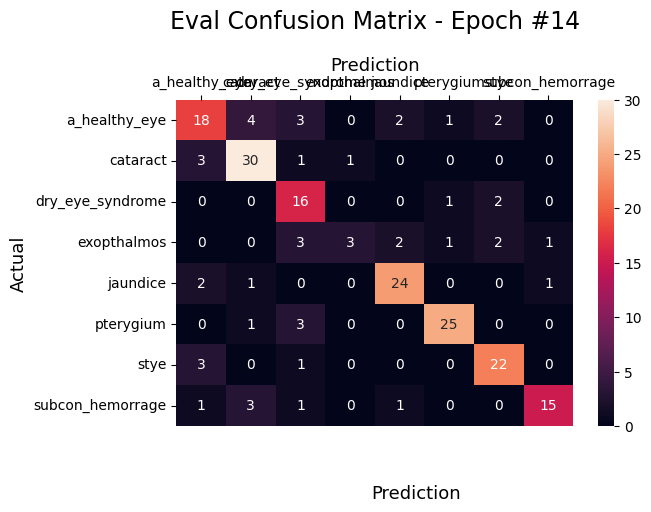

Current f1_score ->  0.7277284458310493
Epoch #15 -> lr = 0.00030449201363283917
Training: 
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       329
           1       0.87      0.87      0.87       298
           2       0.79      0.81      0.80       206
           3       0.85      0.81      0.83        79
           4       0.93      0.94      0.94       181
           5       0.90      0.91      0.91       276
           6       0.87      0.84      0.86       260
           7       0.82      0.82      0.82       162

    accuracy                           0.87      1791
   macro avg       0.86      0.86      0.86      1791
weighted avg       0.87      0.87      0.87      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        30
           1       0.81      0.60      0.69        35
           2       0.53      0.47      0.50        19
           3       0.67    

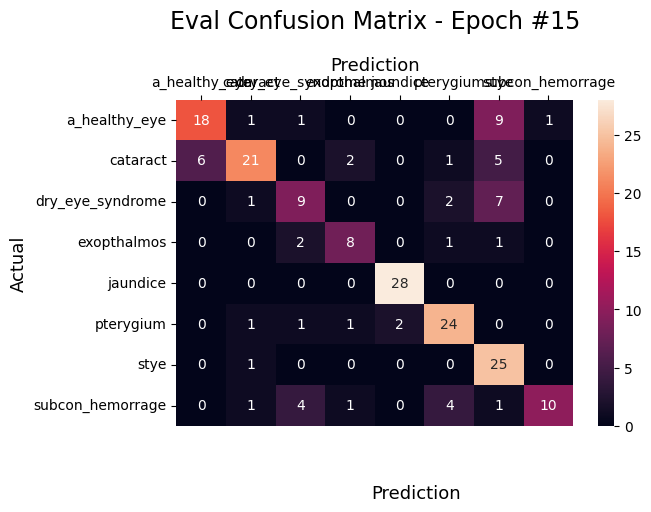

Current f1_score ->  0.6968670108067366
Epoch #16 -> lr = 0.0003051562249131788
Training: 
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       329
           1       0.86      0.86      0.86       298
           2       0.82      0.89      0.86       206
           3       0.90      0.89      0.89        79
           4       0.95      0.91      0.93       181
           5       0.92      0.91      0.91       276
           6       0.89      0.90      0.90       260
           7       0.88      0.85      0.86       162

    accuracy                           0.89      1791
   macro avg       0.89      0.89      0.89      1791
weighted avg       0.89      0.89      0.89      1791

Evaluation: 
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        30
           1       0.66      0.83      0.73        35
           2       1.00      0.37      0.54        19
           3       0.67     

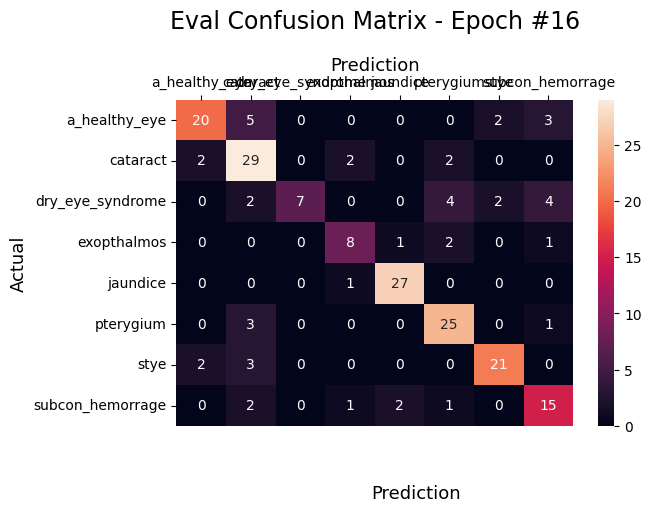

Current f1_score ->  0.7368659394874508
Early stopping on epoch #16
Loading best model from saved history.


Eval/Accuracy,▁▂▃▅▅▅▅▇▇▅▇█▇█▇█
Eval/F1-Score,▁▃▄▅▅▅▆▆▇▆▇█▇▇▇▇
Eval/Precision,▁▃▄▅▆▇▇▆▇▆▇███▇█
Eval/Recall,▁▂▃▄▄▅▅▆▇▆▇█▇▇▇▇
Train/Accuracy,▁▃▅▅▆▆▇▇▇▇▇█████
Train/F1-Score,▁▃▅▅▆▆▇▇▇▇▇█████
Train/Precision,▁▃▅▅▆▆▇▇▇▇▇█████
Train/Recall,▁▃▅▅▆▆▇▇▇▇▇█████
Eval/Accuracy,0.76
Eval/F1-Score,0.73687
Eval/Precision,0.78242


In [38]:
models_dict = []
best_eval_f1 = 0
patience = 4
patience_counter = 0

for i in range(num_epochs):
    
    current_lr = scheduler.get_last_lr()[0]
    
    epoch_message = f"Epoch #{i+1} -> lr = {current_lr}"
    print(epoch_message)
    f.write(epoch_message + "\n")
    
    train_actual, train_predicted = model_train(model, optimizer, criterion, train_loader)
    eval_actual, eval_predicted = model_eval(model, test_loader)
    
    train_report = classification_report(train_actual, train_predicted, output_dict=True)
    train_report_message = "Training: \n" + str(classification_report(train_actual, train_predicted, zero_division=0))
    print(train_report_message)
    f.write(train_report_message + "\n")
    
    eval_report = classification_report(eval_actual, eval_predicted, output_dict=True)
    eval_report_message = "Evaluation: \n" + str(classification_report(eval_actual, eval_predicted, zero_division=0))
    print(eval_report_message)
    f.write(eval_report_message + "\n")
    
    wandb.log({
        "Train/Precision": train_report["macro avg"]['precision'], 
        "Train/Recall": train_report["macro avg"]['recall'],
        "Train/F1-Score": train_report["macro avg"]['f1-score'],
        "Train/Accuracy": train_report["accuracy"],
        
        "Eval/Precision": eval_report["macro avg"]['precision'], 
        "Eval/Recall": eval_report["macro avg"]['recall'],
        "Eval/F1-Score": eval_report["macro avg"]['f1-score'],
        "Eval/Accuracy": eval_report["accuracy"]
    })
    
    create_confusion_matrix(eval_actual, eval_predicted, i)
    
    models_dict.append(copy.deepcopy(model.state_dict()))
    if len(models_dict) > 4:
        models_dict.pop(0)
    
    eval_f1 = eval_report["macro avg"]['f1-score']
    print("Current f1_score -> ", eval_f1)
    
    if eval_f1 > best_eval_f1:
        best_eval_f1 = eval_f1
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping on epoch #{i+1}")
            print("Loading best model from saved history.")
            model.load_state_dict(models_dict[0])
            break
    
    scheduler.step()

wandb.finish()   
f.close() 

Validation: 
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        30
           1       0.66      0.83      0.73        35
           2       1.00      0.37      0.54        19
           3       0.67      0.67      0.67        12
           4       0.90      0.96      0.93        28
           5       0.74      0.86      0.79        29
           6       0.84      0.81      0.82        26
           7       0.62      0.71      0.67        21

    accuracy                           0.76       200
   macro avg       0.78      0.73      0.74       200
weighted avg       0.78      0.76      0.75       200



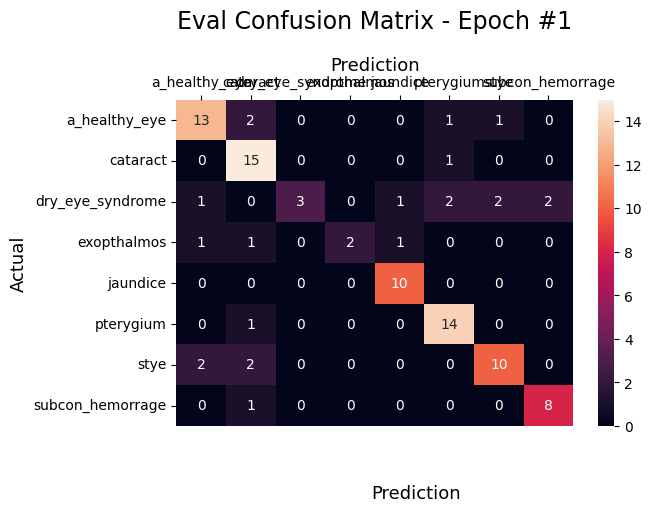

In [39]:
validation_actual, validation_predicted = model_eval(model, val_loader)

validation_report = classification_report(validation_actual, validation_predicted, output_dict=True)
validation_report_message = "Validation: \n" + str(classification_report(eval_actual, eval_predicted, zero_division=0))
print(validation_report_message)
    
create_confusion_matrix(validation_actual, validation_predicted, 0)

In [40]:
torch.save(model.state_dict(), "../models_info/classification_model_Adam_early_stopping_5.pth")